# Проект. Компьютерное зрение
## Глава 0. Входные данные
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

### План проекта:
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

### Описание данных
Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).   
Они находятся в папке `/datasets/faces/`.  
В распоряжении одна папка со всеми изображениями (`/final_files`) и csv-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

# Глава 1. Исследовательский анализ данных

Вызовем все необходимые библиотеки для реализации проекта

In [22]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly
import plotly.graph_objs as go
sns.set()

Загрузим данные из файла csv и создадим ДатаФрейм `labels`, выведем содержимое

In [2]:
#labels = pd.read_csv('/datasets/faces/labels.csv')
labels = pd.read_csv('labels.csv') 
labels

,Unnamed: 0,file_name,real_age
0,0,000000.jpg,4
1,1,000001.jpg,18
2,2,000002.jpg,80
3,3,000003.jpg,50
4,4,000004.jpg,17
...,...,...,...
7586,7586,007608.jpg,14
7587,7587,007609.jpg,37
7588,7588,007610.jpg,28
7589,7589,007611.jpg,20


Колонка `file_name` содержит название файла, `real_age` реальный возраст человека.

Выведем общую информацию о ДатаФрейме

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 3 columns):
Unnamed: 0    7591 non-null int64
file_name     7591 non-null object
real_age      7591 non-null int64
dtypes: int64(2), object(1)
memory usage: 178.0+ KB


Размер выборки составляет 7591 фото.  
Построим  гистограмму распределения возраста в выборке.

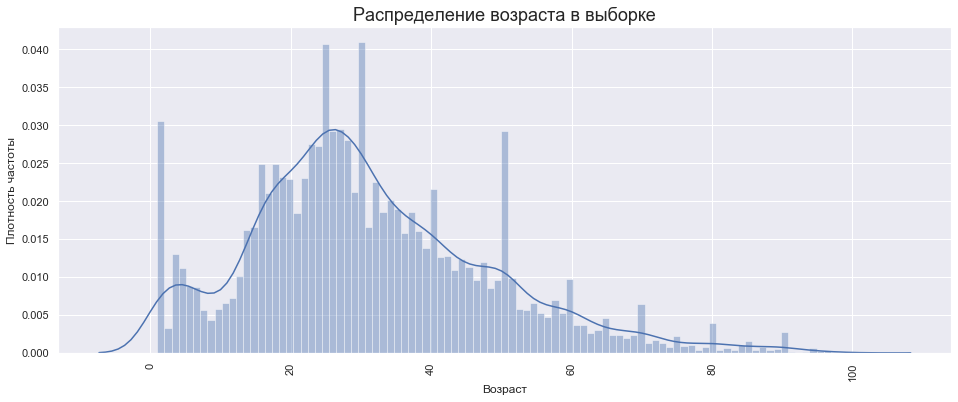

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(labels['real_age'], bins=len(labels['real_age'].unique()))
ax.set_title('Распределение возраста в выборке', fontdict={'fontsize': 18})
plt.xticks(rotation=90)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Плотность частоты', fontsize=12);

Численное распределение в прорядке возрастания возраста

In [5]:
labels['real_age'].value_counts().sort_index()

1      149
2       88
3       25
4      101
5       87
      ... 
94       5
95       2
96       2
97       1
100      1
Name: real_age, Length: 97, dtype: int64

Отсортированое по убыванию количества людей в каждом возрасте

In [6]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
100      1
93       1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

Постороим Boxplot распределения фото по возрасту в годах

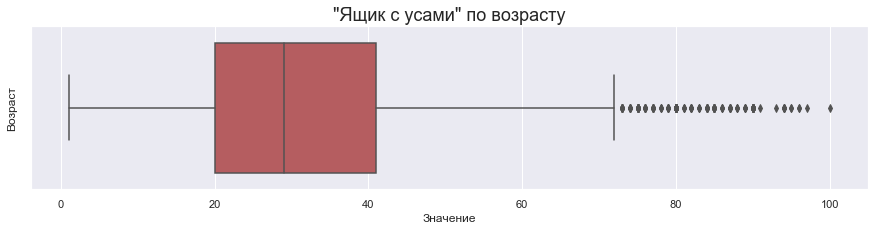

In [25]:
plt.figure(figsize=(15,3))
sns.boxplot(labels['real_age'], color='r').set(xlabel='Значение', ylabel='Возраст')                          
plt.title(label='"Ящик с усами" по возрасту', fontdict={'fontsize': 18})
plt.show()

По графикам видно, что распределение выборки имеет вид ближе к бимодальное распределению плюс со смещением вправо.  
Медиана - 29 лет, q1 и q3 - 20 и 41 соответственно.  
Нижний 'ус' и верхний 'ус' - 1 и 72 соответственно. 

Выведем первое изображение

In [52]:
image = Image.open('/datasets/faces/final_files/' + labels.loc[0, 'file_name'])
array = np.array(image)

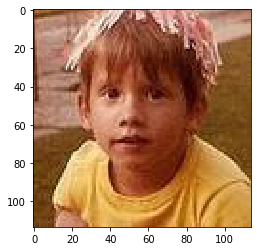

In [53]:
plt.imshow(array);

Создадим загрузчик **ImageDataGenerator**

In [54]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        seed=17)

Found 7591 validated image filenames.


Напечатаем на экране 16 фотографий

In [55]:
features, target = next(train_gen_flow)

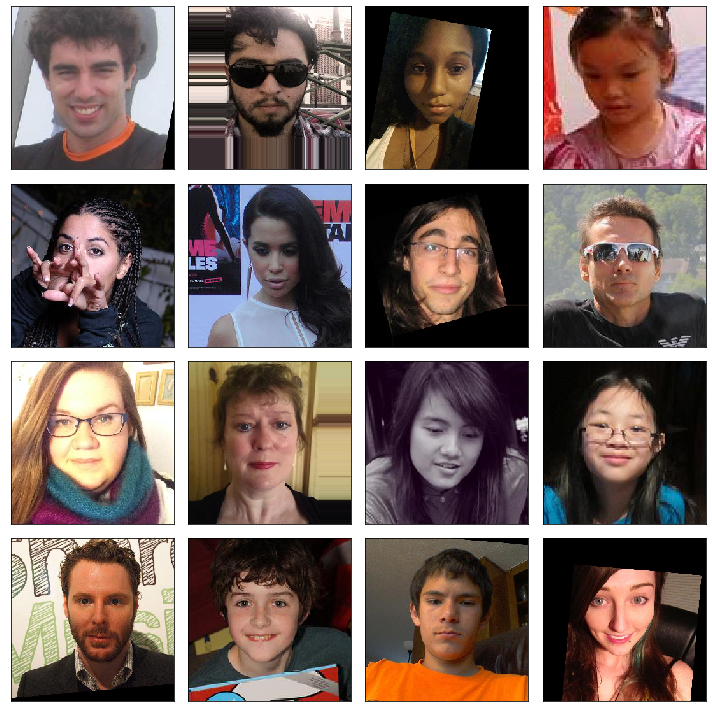

In [56]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы по главе 1:

> - Данные представлены ввиде изображений и меток, какой возраст человека на фото
- Не на всех фото четкие лица, есть фото в очках или прикрытые, а также черно-белые фото.
- Проанализировали распределение данных в датасете по средством построения графиков распределения
- Распределение данных имеет вид бимодального распределения с длинных хвостом
- Медиана - 29 лет, а верхгий 'ус' - 72 года. Это говорит о том, что модель будет обучаться на неравномернораспределенной выборке, вероятно, там где больше фото для года модель лучше обучиться и будет иметь меньший штраф за предсказание, и наоборот, для возраста больше 72 лет больший штраф. 

# Глава 2. Обучение модели

Обучим модель в GPU-тренажёре и сохраните результат вывода модели на экран.

#### Постановка задачи:
Построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей. Добится значения MAE на тестовой выборке не больше 8.
Напищем функции:  
`load_train(path)` - принимает путь к ДатаФрейму и папке с фото, используя загрузчик ImageDataGenerator, возвращает обучающую выборку,  
`load_test(path)` - тоже самое для тестовой выборки,  
`create_model(input_shape)` - принимает размер входного тензора, возвращает созданую модель,  
`train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - обучает модель и оценивает на тестовой выборке.

Перенесем сюда код обучения модели и её результат вывода на экран.
(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Импортируем нодбходимые инструменты из библиотеки `tensorflow.keras`

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

```

Напишем функции `load_train(path)` и `load_test(path)`  
Отнормируем значения к [0, 1], добавим вертикальную аугментацию, приведем изображения к размеру 256х256, количество изображений в батче - 32

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        vertical_flip=True, 
        validation_split=0.2)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

```

Напишем функцию `create_model(input_shape)`  
Оптимизатор укажем - Adam, свёрточную нейронную сеть возьмем ResNet50 c 50 слоями, обучение на MSE, контрольная метрика МАЕ

```python

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

```

Напишем функцию `train_model`  
Количество эпох возьмем 50

```python

def train_model(model, train_gen_flow, test_gen_flow, batch_size=None, epochs=50, 
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_gen_flow)
    if validation_steps is None:
        validation_steps = len(test_gen_flow)
    model.fit(train_gen_flow,
              validation_data=test_gen_flow,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)             
    return model

```

Скопируем и вставим результат, полученный при обучении и тесте модели

```

Train for 190 steps, validate for 48 steps
Epoch 1/50
2020-06-28 15:43:33.850600: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-06-28 15:43:34.168998: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 53s - loss: 260.8179 - mae: 11.7646 - val_loss: 813.2366 - val_mae: 23.4676
Epoch 2/50
190/190 - 44s - loss: 93.6342 - mae: 7.3241 - val_loss: 679.5106 - val_mae: 20.8023
Epoch 3/50
190/190 - 44s - loss: 64.7543 - mae: 6.0414 - val_loss: 253.3209 - val_mae: 11.7286
Epoch 4/50
190/190 - 43s - loss: 46.2686 - mae: 5.1959 - val_loss: 122.4325 - val_mae: 8.2485
Epoch 5/50
190/190 - 43s - loss: 35.7736 - mae: 4.5434 - val_loss: 159.8702 - val_mae: 10.2423
Epoch 6/50
190/190 - 43s - loss: 28.6329 - mae: 4.0945 - val_loss: 80.6753 - val_mae: 6.8275
Epoch 7/50
190/190 - 43s - loss: 23.8650 - mae: 3.7386 - val_loss: 70.2518 - val_mae: 6.2617
Epoch 8/50
190/190 - 43s - loss: 19.8987 - mae: 3.4354 - val_loss: 71.3786 - val_mae: 6.3499
Epoch 9/50
190/190 - 43s - loss: 17.6062 - mae: 3.2451 - val_loss: 69.0420 - val_mae: 6.2888
Epoch 10/50
190/190 - 44s - loss: 15.1694 - mae: 3.0210 - val_loss: 73.3064 - val_mae: 6.5995
Epoch 11/50
190/190 - 44s - loss: 14.2871 - mae: 2.9148 - val_loss: 79.9240 - val_mae: 6.9175
Epoch 12/50
190/190 - 43s - loss: 12.9895 - mae: 2.7723 - val_loss: 74.3649 - val_mae: 6.6166
Epoch 13/50
190/190 - 44s - loss: 12.1115 - mae: 2.6523 - val_loss: 71.1221 - val_mae: 6.4466
Epoch 14/50
190/190 - 43s - loss: 11.4261 - mae: 2.5746 - val_loss: 73.9950 - val_mae: 6.4003
Epoch 15/50
190/190 - 44s - loss: 11.3068 - mae: 2.5405 - val_loss: 76.2390 - val_mae: 6.8220
Epoch 16/50
190/190 - 44s - loss: 10.6985 - mae: 2.4745 - val_loss: 67.0990 - val_mae: 6.2165
Epoch 17/50
190/190 - 44s - loss: 10.6323 - mae: 2.4571 - val_loss: 81.6187 - val_mae: 6.7933
Epoch 18/50
190/190 - 43s - loss: 10.3724 - mae: 2.4521 - val_loss: 71.7903 - val_mae: 6.4238
Epoch 19/50
190/190 - 43s - loss: 9.9625 - mae: 2.3865 - val_loss: 66.8203 - val_mae: 6.2301
Epoch 20/50
190/190 - 43s - loss: 9.9278 - mae: 2.3710 - val_loss: 69.5364 - val_mae: 6.3639
Epoch 21/50
190/190 - 43s - loss: 8.7770 - mae: 2.2459 - val_loss: 66.4091 - val_mae: 6.0973
Epoch 22/50
190/190 - 44s - loss: 7.5360 - mae: 2.0908 - val_loss: 66.6716 - val_mae: 6.2037
Epoch 23/50
190/190 - 43s - loss: 7.6556 - mae: 2.0924 - val_loss: 70.7800 - val_mae: 6.2632
Epoch 24/50
190/190 - 44s - loss: 7.0073 - mae: 2.0047 - val_loss: 66.8972 - val_mae: 6.1372
Epoch 25/50
190/190 - 44s - loss: 7.0400 - mae: 2.0029 - val_loss: 62.9382 - val_mae: 5.9743
Epoch 26/50
190/190 - 43s - loss: 6.8087 - mae: 1.9776 - val_loss: 64.6565 - val_mae: 6.0140
Epoch 27/50
190/190 - 43s - loss: 6.7507 - mae: 1.9689 - val_loss: 67.3871 - val_mae: 6.2167
Epoch 28/50
190/190 - 44s - loss: 7.1869 - mae: 2.0298 - val_loss: 64.9217 - val_mae: 6.1575
Epoch 29/50
190/190 - 44s - loss: 7.5592 - mae: 2.0795 - val_loss: 65.3998 - val_mae: 6.0595
Epoch 30/50
190/190 - 44s - loss: 7.6442 - mae: 2.0585 - val_loss: 76.8619 - val_mae: 6.6954
Epoch 31/50
190/190 - 43s - loss: 7.6028 - mae: 2.1014 - val_loss: 65.7443 - val_mae: 6.0393
Epoch 32/50
190/190 - 43s - loss: 7.5788 - mae: 2.0909 - val_loss: 68.1259 - val_mae: 6.2889
Epoch 33/50
190/190 - 43s - loss: 7.6369 - mae: 2.0915 - val_loss: 69.6912 - val_mae: 6.3401
Epoch 34/50
190/190 - 43s - loss: 6.6593 - mae: 1.9575 - val_loss: 69.1320 - val_mae: 6.1725
Epoch 35/50
190/190 - 44s - loss: 6.3808 - mae: 1.8895 - val_loss: 64.0023 - val_mae: 6.0528
Epoch 36/50
190/190 - 44s - loss: 6.0003 - mae: 1.8385 - val_loss: 64.5731 - val_mae: 6.0496
Epoch 37/50
190/190 - 43s - loss: 5.7450 - mae: 1.8228 - val_loss: 75.2858 - val_mae: 6.5941
Epoch 38/50
190/190 - 44s - loss: 5.7561 - mae: 1.8215 - val_loss: 72.1316 - val_mae: 6.4803
Epoch 39/50
190/190 - 43s - loss: 5.9234 - mae: 1.8269 - val_loss: 69.8854 - val_mae: 6.3280
Epoch 40/50
190/190 - 43s - loss: 5.5172 - mae: 1.7749 - val_loss: 67.1938 - val_mae: 6.2746
Epoch 41/50
190/190 - 43s - loss: 5.8199 - mae: 1.8104 - val_loss: 75.6683 - val_mae: 6.6283
Epoch 42/50
190/190 - 44s - loss: 5.5041 - mae: 1.7793 - val_loss: 61.5429 - val_mae: 5.8445
Epoch 43/50
190/190 - 43s - loss: 5.1347 - mae: 1.6972 - val_loss: 69.7292 - val_mae: 6.2401
Epoch 44/50
190/190 - 43s - loss: 5.6785 - mae: 1.7897 - val_loss: 72.7927 - val_mae: 6.4939
Epoch 45/50
190/190 - 43s - loss: 5.5942 - mae: 1.7725 - val_loss: 63.8979 - val_mae: 6.0173
Epoch 46/50
190/190 - 43s - loss: 6.2505 - mae: 1.9049 - val_loss: 69.2638 - val_mae: 6.2999
Epoch 47/50
190/190 - 43s - loss: 5.4209 - mae: 1.7587 - val_loss: 68.6248 - val_mae: 6.2905
Epoch 48/50
190/190 - 43s - loss: 5.1431 - mae: 1.7042 - val_loss: 66.0879 - val_mae: 6.1684
Epoch 49/50
190/190 - 43s - loss: 4.5785 - mae: 1.6150 - val_loss: 62.6028 - val_mae: 5.9220
Epoch 50/50
190/190 - 43s - loss: 4.3928 - mae: 1.5793 - val_loss: 62.1269 - val_mae: 5.8201
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 62.1269 - mae: 5.8201
Test MAE: 5.8201

```

### Выводы по главе 2:

> - Обучили свёрточную нейронную сеть с архитектурой ResNet50 (как оптимальную в соотношении вресени обучения - качества)
- Получили метрику качества МАЕ - 5.82. Модель в среднем ошибается на это значение при прогнозе возраста.

# Общий вывод. Анализ обученной модели

**Анализ данных показал:**
- Данные распределены не равномерно, медиана 29 лет, основная масса от 20 до 41 года. Имеем более молодое поколение в выборке, а значит модель лучше обучиться на этом возрасте, а большие значения ошибки будут после возраста 72.  

**Анализ обученной модели:**
- Обученная свёрточная нейронная сеть ResNet50 показала метрику качества 5.82, что довольно хороший результат ([В статье о датасете](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), с которым работали, значение MAE равно 5.4).
- Нейронная сеть ошибается в среднем на 5.82 года при прогнозе возраста по фото. Это дает возможность: 
    - Проанализировав покупки, можно предлагать на кассе товары, которые могут заинтересовать покупателей этой возрастной группы
    - Контролировать добросовестность кассиров при продаже алкоголя.
    
Нейронная сеть соответствует поставленной задаче сетевого супермаркета и может быть внедрена в систему слежения, что повысит средний чек покупателей за счет рекомендации потенциально интересных товаров для возрастных групп, а также снизит риск продажи алкоголя и табака несовершеннолетним.